# Programming task — MDS

In [50]:
import os
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_theme()

import warnings

warnings.filterwarnings("ignore")

## Importing data

In [23]:
def download_data():
    voting_data_url = 'https://cadmus.eui.eu/bitstream/handle/1814/74918/VoteWatch-EP-voting-data_2004-2022.zip?sequence=2&isAllowed=y'
    urllib.request.urlretrieve(
        voting_data_url, 'VoteWatch-EP-voting-data_2004-2022.zip')
    with zipfile.ZipFile('VoteWatch-EP-voting-data_2004-2022.zip', 'r') as zip_ref:
        zip_ref.extractall('VoteWatch-EP-voting-data_2004-2022')
    os.remove('VoteWatch-EP-voting-data_2004-2022.zip')
    eu_council_url = 'https://cadmus.eui.eu/bitstream/handle/1814/74918/EU-Council-votes-July-2009-to-Feb-2022.zip?sequence=3&isAllowed=y'
    urllib.request.urlretrieve(
        eu_council_url, 'EU-Council-votes-July-2009-to-Feb-2022.zip')
    with zipfile.ZipFile('EU-Council-votes-July-2009-to-Feb-2022.zip', 'r') as zip_ref:
        zip_ref.extractall('EU-Council-votes-July-2009-to-Feb-2022')
    os.remove('EU-Council-votes-July-2009-to-Feb-2022.zip')

In [24]:
download_data()

In [25]:
ep6 = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP6_RCVs_2022_06_13.xlsx', header=1)
ep7 = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP7_RCVs_2014_06_19.xlsx', header=0)
ep8 = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP8_RCVs_2019_06_25.xlsx', header=0)
ep9 = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP9_RCVs_2022_06_22.xlsx', header=0)


In [26]:
ep6_voted = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP6_Voted docs.xlsx', header=0)
ep7_voted = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP7_Voted docs.xlsx', header=0)
ep8_voted = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP8_Voted docs.xlsx', header=0)
ep9_voted = pd.read_excel(
    'VoteWatch-EP-voting-data_2004-2022/EP9_Voted docs.xlsx', header=0)

In [27]:
votes = pd.read_excel(
    'EU-Council-votes-July-2009-to-Feb-2022/EU-Council-votes-July-2009-to-Feb-2022.xlsx', header=0)

In [28]:
rcv_legend = ['not a MEP', 'for', 'against',
              'abstention', 'absent', 'didn\'t vote', 'motivated']

In [29]:
ep6 = ep6.drop(index=0, errors='ignore') # The only one with the first row is NaN

## Pre-processing

In [84]:
countries_label = ep6['Country'].unique().tolist()
countries_label

['Cyprus',
 'Poland',
 'Italy',
 'United Kingdom',
 'Germany',
 'Sweden',
 'Latvia',
 'Lithuania',
 'France',
 'Greece',
 'Portugal',
 'Malta',
 'Denmark',
 'Spain',
 'Ireland',
 'Slovakia',
 'Hungary',
 'Netherlands',
 'Belgium',
 'Austria',
 'Czech Republic',
 'Slovenia',
 'Luxembourg',
 'Finland',
 'Estonia',
 'Bulgaria',
 'Romania']

In [85]:
epgs_label = ep6['EPG'].unique().tolist()
epgs_label

['Confederal Group of the European United Left - Nordic Green Left',
 'Independence/Democracy Group',
 "Group of the European People's Party (Christian Democrats) and European Democrats",
 'Non-attached Members',
 'Group of the Alliance of Liberals and Democrats for Europe',
 'Socialist Group in the European Parliament',
 'Union for Europe of the Nations Group',
 'Group of the Greens/European Free Alliance']

In [ ]:
def get_country_mp(i):
    """
    Returns the country of the i-th MP

    Parameters
    ----------
    i : int
        The index of the MP
    """
    return ep6['Country'][i]

In [ ]:
def get_epg_mp(i):
    """
    Returns the EPG of the i-th MP

    Parameters
    ----------
    i : int
        The index of the MP
    """
    return ep6['EPG'][i]

In [32]:
def get_first_vot_col(df):
    """
    Returns the index of the first column containing voting data

    Parameters
    ----------
    df : pandas.DataFrame
        A dataframe containing voting data
    """
    return np.nonzero(df.columns == '1')[0][0]

In [56]:
def vote_sim(df, i, j, first_vot_col=-1):
    """
    Returns the percentage of votes that two MEPs have in common

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the voting data
    i : int
        The row index of the first MEP
    j : int
        The row index of the second MEP
    """
    if first_vot_col < 0:
        first_vot_col = get_first_vot_col(df)
    n_cols = len(df.columns)
    return np.mean(df.iloc[i, first_vot_col:n_cols] == df.iloc[j, first_vot_col:n_cols])

In [57]:
def cos_sim(df, i, j, first_vot_col=-1):
    """
    Returns the cosine similarity between two MEPs

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the voting data
    i : int
        The row index of the first MEP
    j : int
        The row index of the second MEP
    """
    if first_vot_col < 0:
        first_vot_col = get_first_vot_col(df)
    n_cols = len(df.columns)
    return np.dot(df.iloc[i, first_vot_col:n_cols], df.iloc[j, first_vot_col:n_cols])/(np.linalg.norm(df.iloc[i, first_vot_col:n_cols])*np.linalg.norm(df.iloc[j, first_vot_col:n_cols]))

In [66]:
def matrix_cos_sim(df):
    """
    Returns the cosine similarity matrix between all MEPs

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the voting data
    """
    cos_sim_matrix = np.zeros((len(df), len(df)))
    first_vot_col = get_first_vot_col(df)
    for i in tqdm(range(len(df))):
        for j in tqdm(range(i, len(df)), leave=False):
            cos_sim_matrix[i, j] = cos_sim(df, i, j, first_vot_col)
            cos_sim_matrix[j, i] = cos_sim_matrix[i, j]
    return cos_sim_matrix

def matrix_vote_sim(df):
    """
    Returns the voting similarity matrix between all MEPs

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the voting data
    """
    vote_sim_matrix = np.zeros((len(df), len(df)))
    first_vot_col = get_first_vot_col(df)
    for i in tqdm(range(len(df))):
        for j in tqdm(range(i, len(df)), leave=False):
            vote_sim_matrix[i, j] = vote_sim(df, i, j, first_vot_col)
            vote_sim_matrix[j, i] = vote_sim_matrix[i, j]
    return vote_sim_matrix

In [67]:
matrix_cos_ep6 = matrix_cos_sim(ep6[:100])
matrix_vote_ep6 = matrix_vote_sim(ep6[:100])

100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


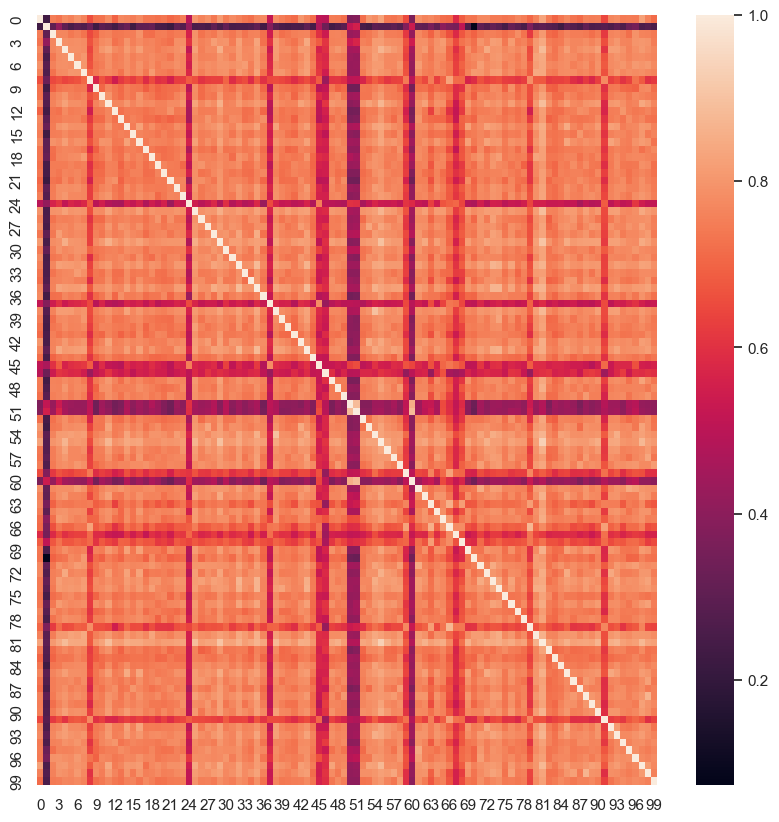

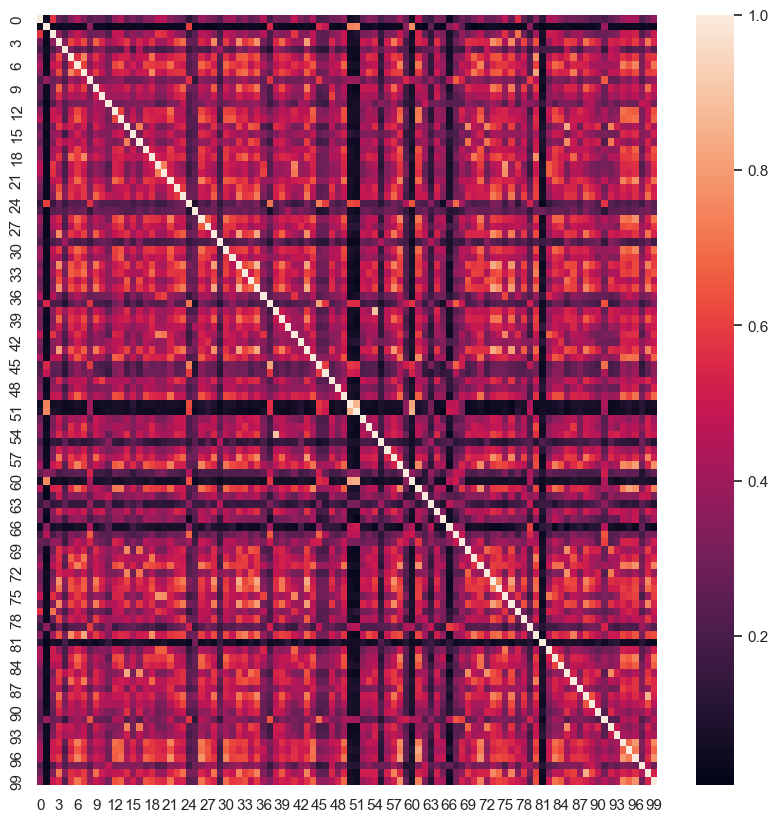

In [68]:
# Plot cosine similarity matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix_cos_ep6, ax=ax)
plt.show()

# Plot voting similarity matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix_vote_ep6, ax=ax)
plt.show()

In [69]:
def mds(df, metric='cosine'):
    """
    Returns the MDS coordinates of a dataframe not using built-in functions

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the voting data
    metric : str
        The metric used to calculate the distance between MEPs
    """
    if metric == 'cosine':
        dist_matrix = 1-matrix_cos_sim(df)
    elif metric == 'vote':
        dist_matrix = 1-matrix_vote_sim(df)
    dist_matrix = dist_matrix**2
    n = len(df)
    J = np.eye(n) - np.ones((n, n))/n
    B = -0.5*np.dot(np.dot(J, dist_matrix), J)
    eig_vals, eig_vects = np.linalg.eigh(B)
    idx = eig_vals.argsort()[::-1]
    eig_vals = eig_vals[idx]
    eig_vects = eig_vects[:, idx]
    eig_vals = np.maximum(eig_vals, 0)
    eig_vals = np.sqrt(eig_vals)
    X = np.dot(eig_vects, np.diag(eig_vals))
    return X

In [96]:
number_of_meps = 200

mds_coordinates = mds(ep6[:number_of_meps])

100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


InvalidIndexError: (slice(None, 200, None), slice(10, None, None))

In [111]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed')
true_mds_coordinates = mds.fit_transform(1-matrix_cos_sim(ep6[:number_of_meps]))

100%|██████████| 200/200 [01:25<00:00,  2.34it/s]


In [112]:
countries = ep6['Country'][:number_of_meps]
epgs = ep6['EPG'][:number_of_meps]
# To lists
countries = countries.to_list()
epgs = epgs.to_list()
# To colors
countries_colors = [countries_label.index(country) for country in countries]
epgs_colors = [epgs_label.index(epg) for epg in epgs]

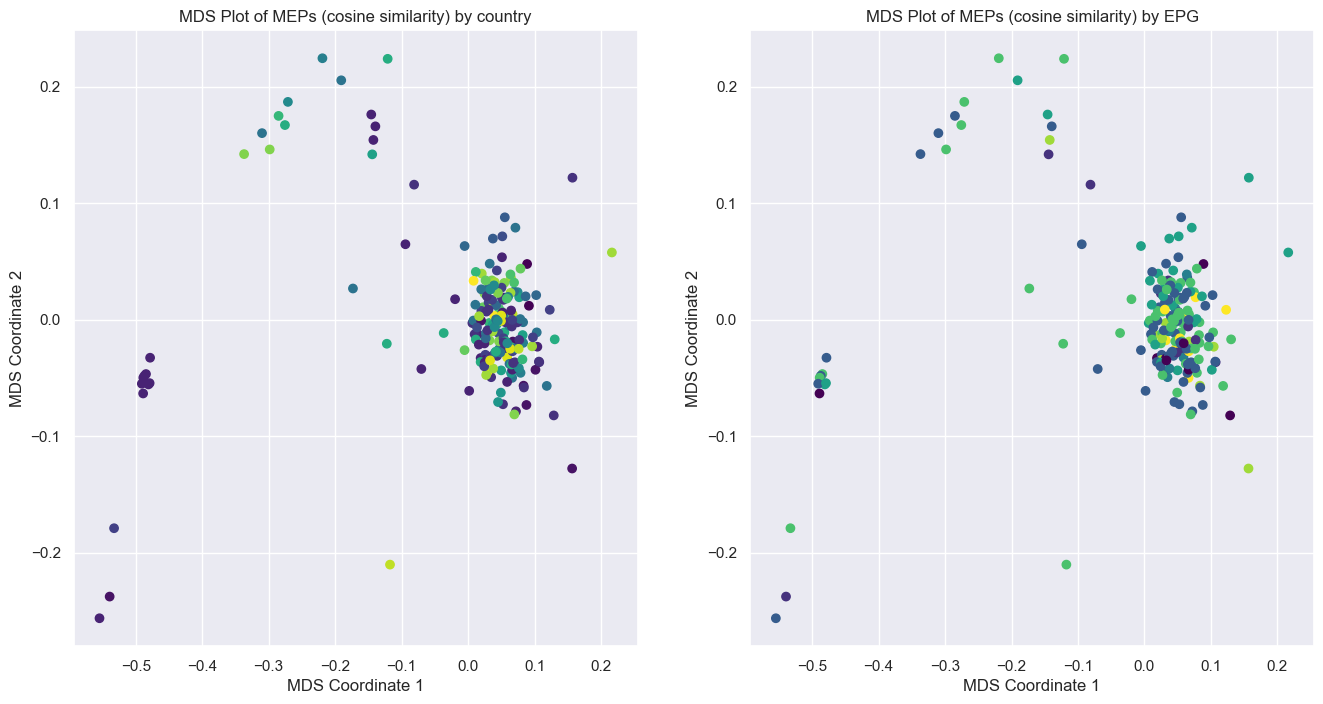

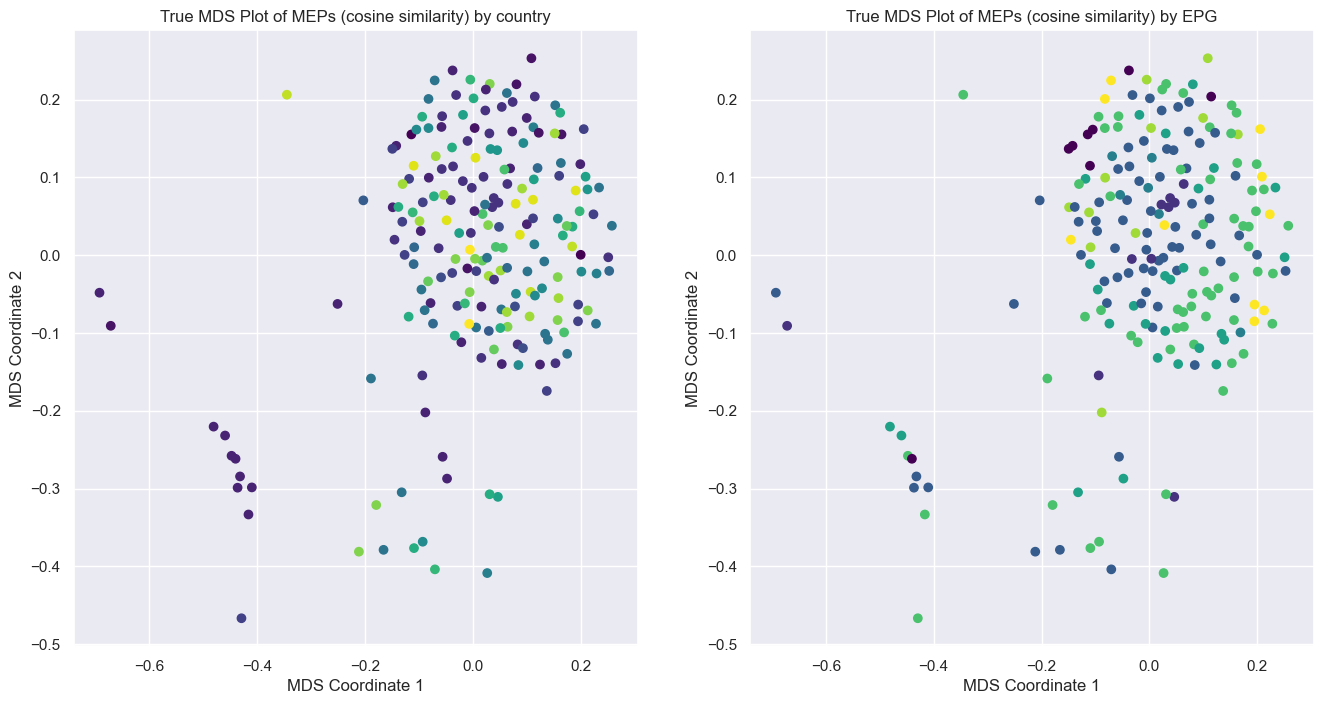

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=countries_colors, cmap='viridis')
axs[0].set_title("MDS Plot of MEPs (cosine similarity) by country")
axs[0].set_xlabel("MDS Coordinate 1")
axs[0].set_ylabel("MDS Coordinate 2")

axs[1].scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=epgs_colors, cmap='viridis')
axs[1].set_title("MDS Plot of MEPs (cosine similarity) by EPG")
axs[1].set_xlabel("MDS Coordinate 1")
axs[1].set_ylabel("MDS Coordinate 2")

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].scatter(true_mds_coordinates[:, 0], true_mds_coordinates[:, 1], c=countries_colors, cmap='viridis')
axs[0].set_title("True MDS Plot of MEPs (cosine similarity) by country")
axs[0].set_xlabel("MDS Coordinate 1")
axs[0].set_ylabel("MDS Coordinate 2")

axs[1].scatter(true_mds_coordinates[:, 0], true_mds_coordinates[:, 1], c=epgs_colors, cmap='viridis')
axs[1].set_title("True MDS Plot of MEPs (cosine similarity) by EPG")
axs[1].set_xlabel("MDS Coordinate 1")
axs[1].set_ylabel("MDS Coordinate 2")

plt.show()

